In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Nomenclature 



- SOC: state of charge in [0,1]
- CT: charging time (s)
- DT: discharging time (s)
- NEC: nominal energy capacity (Wh)
- EC: energy capacity (Wh)
- CPL: charging power level (W)
- DPL: discharging power level (W)

# Auxiliary functions 

In [2]:
def get_SOC_CT_functions(SOC_to_CPL_function, NEC):
    '''
    Approximates SOC -> CT and CT -> SOC functions from the SOC -> CPL function
    '''
    # start with empty battery and charging time = 0
    CT = [0]
    EC = 0
    SOC = [0]

    while EC < NEC : # until battery is full
        EC = EC + 1/3600 * SOC_to_CPL_function(SOC[-1]) # charge the battery for one sec using appropriate CPL
        CT.append(CT[-1]+1) # update time 
        SOC.append(EC/NEC) # update SOC 
    
    # interpolate data to get functions
    SOC_to_CT_function = interp1d(SOC, CT) 
    CT_to_SOC_function = interp1d(CT+[np.inf], SOC+[1.])

    return SOC_to_CT_function, CT_to_SOC_function


def get_SOC_DT_functions(SOC_to_DPL_function, NEC):
    '''
    Approximates SOC -> DT and DT -> SOC functions from the SOC -> CPL function
    '''
    # start with fully charged battery
    DT = [0]
    EC = NEC
    SOC = [1.]
    # iteratively discharge the battery
    while EC >0 :
        EC = EC - 1/3600 * SOC_to_DPL_function(SOC[-1])
        DT.append(DT[-1]+1)
        SOC.append(EC/NEC)
    
    SOC_to_DT_function = interp1d(SOC, DT)
    DT_to_SOC_function = interp1d(DT+[np.inf], SOC+[0.])

    return SOC_to_DT_function, DT_to_SOC_function


    

# Battery class :

In [3]:
class Battery():
    '''
    Battery class. 

    Nomenclature :
    - SOC: state of charge in [0,1]
    - CT: charging time (s)
    - DT: discharging time (s)
    - NEC: nominal energy capacity (Wh)
    - EC: energy capacity (Wh)
    - CPL: charging power level (W)
    - DPL: discharging power level (W)
    '''

    def __init__(self,SOC_to_CPL_function, SOC_to_DPL_function, NEC = 75000):
        self.NEC = NEC 
        self.EC = NEC ## initialize fully-charged battery 
        self.SOC_to_CPL_function = SOC_to_CPL_function ## SOC [0,1] to Charging Power Level in Watts
        self.SOC_to_DPL_function = SOC_to_DPL_function ## SOC [0,1] to Discharging Power Level in Watts
        self.SOC_to_CT_function, self.CT_to_SOC_function = get_SOC_CT_functions(SOC_to_CPL_function, NEC) 
        self.SOC_to_DT_function, self.DT_to_SOC_function = get_SOC_DT_functions(SOC_to_DPL_function, NEC)

    @ property
    def SOC(self) :
        return self.EC/self.NEC
        

    def charge(self,max_charging_time):
        '''
        Charges the battery for a maximum duration of max_charging_time. 
        Returns the updated SOC and the charging time (strictly less than max_charging_time if 
        less time than max_charging_time was needed to fully charge the battery)
        '''
        initial_CT = self.SOC_to_CT_function(self.SOC) # For how long the battery has already been charging 
        final_SOC = self.CT_to_SOC_function(initial_CT+max_charging_time) # SOC after charging 
        time_to_charge = self.SOC_to_CT_function(final_SOC)-initial_CT # Time it took to reach updated SOC 
        self.EC = final_SOC * self.NEC 
        return final_SOC, time_to_charge

    def discharge(self,max_discharging_time):
        '''
        Discharges the battery for a maximum duration of max_discharging_time. 
        Returns the updated SOC and the discharging time (strictly less than max_discharging_time if 
        less time than max_discharging_time was needed to fully discharge the battery)
        '''
        initial_DT = self.SOC_to_DT_function(self.SOC)
        final_SOC = self.DT_to_SOC_function(initial_DT+max_discharging_time)
        time_to_discharge = self.SOC_to_DT_function(final_SOC)-initial_DT
        self.EC = final_SOC * self.NEC
        return final_SOC, time_to_discharge


        
        

    
    
        

# Initialize battery 

## sample charging/ discharging Curve :


- 75kWh battery
- Charging curve : theoretical C-value is maximized to 0.5 kW/kWh for the battery state from 0% to ~85% and then it is going down almost linear to zero


<img src="../assets/curve.png" width="600"/>

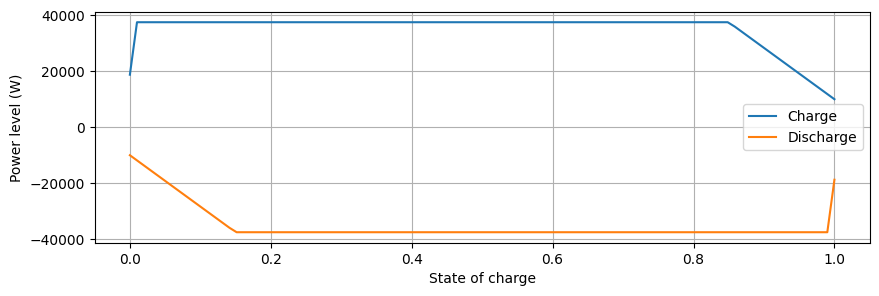

In [4]:
NEC = 75000
SOC = np.array([0,0.01, 0.85, 1.])

# Charging curve 
CPL = np.array([18750, 37500, 37500, 10000])
SOC_to_CPL_function = interp1d(SOC, CPL)

# Discharging curve 
SOC = np.array([0.  , 0.15, 0.99, 1.  ])
DPL = np.array([10000, 37500, 37500, 18750])
SOC_to_DPL_function = interp1d(SOC, DPL)


plt.figure(figsize=(10,3))
plt.plot(np.linspace(0,1,100), SOC_to_CPL_function(np.linspace(0,1,100)), label = "Charge")
plt.plot(np.linspace(0,1,100), -SOC_to_DPL_function(np.linspace(0,1,100)), label = "Discharge")
plt.grid(True)
plt.xlabel("State of charge")
plt.ylabel("Power level (W)")
plt.legend()





In [5]:
bat1 = Battery(SOC_to_CPL_function, SOC_to_DPL_function, NEC = NEC)

# Charging/discharging the battery

## SOC to charging/ discharging time 

### Charge 

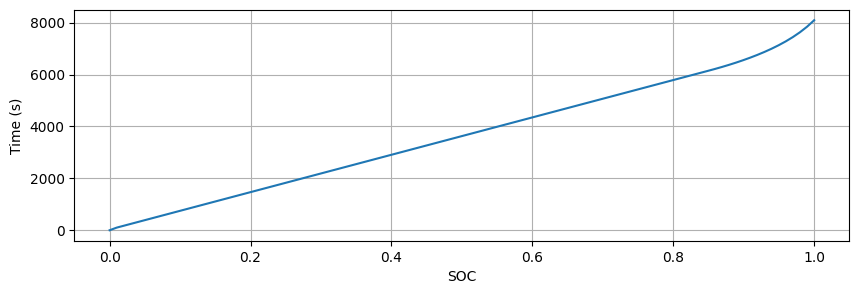

In [6]:
plt.figure(figsize=(10,3))
plt.grid(True)
X = np.linspace(0,1,100)
Y = bat1.SOC_to_CT_function(X)
plt.plot(X,Y)
plt.xlabel("SOC")
plt.ylabel("Time (s)")
plt.show()




The charge takes longer when the battery is close to be fully charged, hence the superlinear curve.

### Discharge

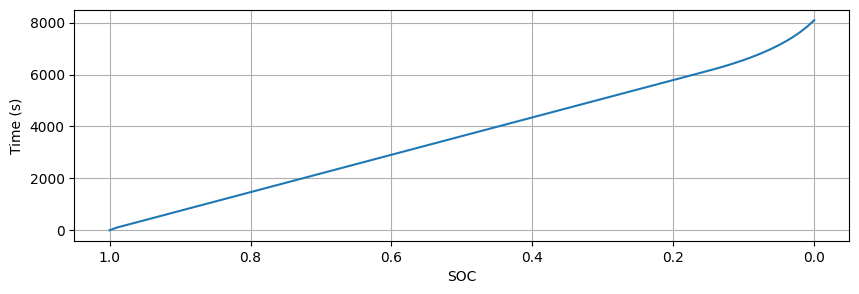

In [7]:
plt.figure(figsize=(10,3))
plt.grid(True)
X = np.linspace(0,1,100)
Y = bat1.SOC_to_DT_function(X)
plt.plot(X,Y)
plt.xlabel("SOC")
plt.ylabel("Time (s)")
plt.gca().invert_xaxis()
plt.show()

- Please mind the reversed x-axis.
- The discharge c-rate is lower at the end of the discharge, hence the superlinear segment between 0.15 and 0.

## Charging/ Discharging time to SOC :

### Charge

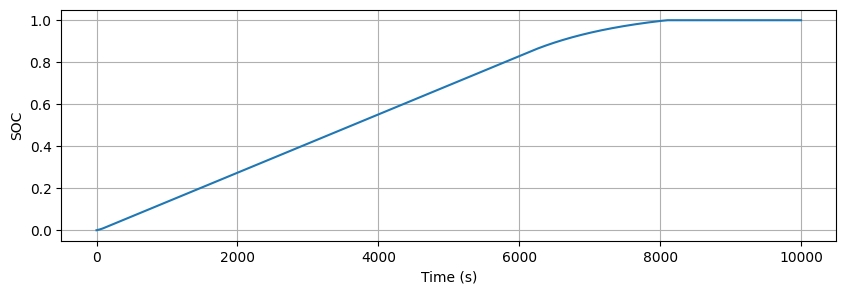

In [8]:
plt.figure(figsize=(10,3))
plt.grid(True)
X = np.linspace(0,10000,10000)
Y = bat1.CT_to_SOC_function(X)
plt.plot(X,Y)
plt.ylabel("SOC")
plt.xlabel("Time (s)")
plt.show()


- CPL decreases linearly at the end of the charge, hence the battery takes more time to charge at the end of the charge.
- Note the charge ends arround 8000s. 

### Discharge

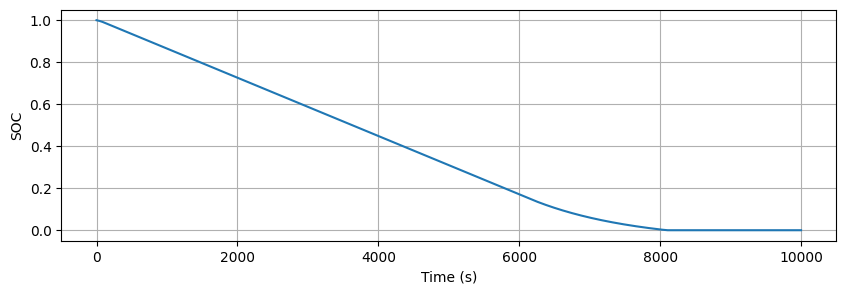

In [9]:
plt.figure(figsize=(10,3))
plt.grid(True)
X = np.linspace(0,10000,10000)
Y = bat1.DT_to_SOC_function(X)
plt.plot(X,Y)
plt.ylabel("SOC")
plt.xlabel("Time (s)")
plt.show()


The discharge power level decreases at the end of the dicharge, hence the slower discharge.

## Charge until specific SOC :

In [10]:

bat1.EC = 0 # Start with empty battery
time_to_charge = bat1.SOC_to_CT_function(0.6) - bat1.SOC_to_CT_function(bat1.SOC) # Get time needed to charge the battery to 0.6
SOC, effective_charging_time = bat1.charge(time_to_charge) 
print("new SOC: ",SOC)
print("planned charging time: ", effective_charging_time)
print("time taken to charge: ", effective_charging_time)


new SOC:  0.6
planned charging time:  4348.159831779874
time taken to charge:  4348.159831779874


## Finish charging :

In [11]:
SOC, time_to_charge = bat1.charge(np.inf)
print("new SOC: ",SOC)
print("time to charge (from 0.6 to 1) :", time_to_charge)

new SOC:  1.0
time to charge (from 0.6 to 1) : 3745.9249926657603


## Disharge until specific SOC :

In [12]:
bat1.EC = bat1.NEC
time_to_discharge = bat1.SOC_to_DT_function(0.6)
SOC, time_to_discharge = bat1.discharge(time_to_discharge)
print("new SOC: ",SOC)
print("time to discharge (from 1 to 0.6) :",time_to_discharge)


new SOC:  0.6
time to discharge (from 1 to 0.6) : 2908.1598317798266


## Finish discharging :

In [13]:
SOC, time_to_discharge = bat1.discharge(np.inf)
print("new SOC: ",SOC)
print("time to time_to_discharge (from 0.6 to 1) :", time_to_discharge)

new SOC:  0.0
time to time_to_discharge (from 0.6 to 1) : 5185.924992665425


# get max energy change in one hour of charge

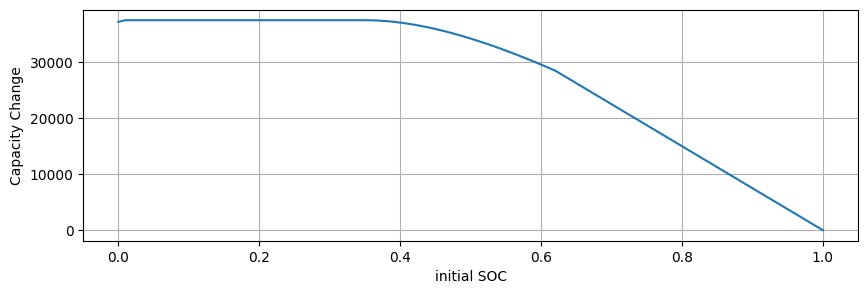

In [19]:
capacity_change = []
time_to_charge = 3600

for initial_SOC in np.linspace(0,1,101) :

    bat1.EC = initial_SOC * bat1.NEC 
    new_SOC, _ = bat1.charge(time_to_charge) 
    capacity_change.append((new_SOC - initial_SOC) * bat1.NEC)
    


plt.figure(figsize=(10,3))
plt.grid(True)
X = np.linspace(0,1,101)
Y = capacity_change
plt.plot(X,Y)
plt.ylabel("Capacity Change")
plt.xlabel("initial SOC")
plt.show()




# get max energy change in one hour of discharge

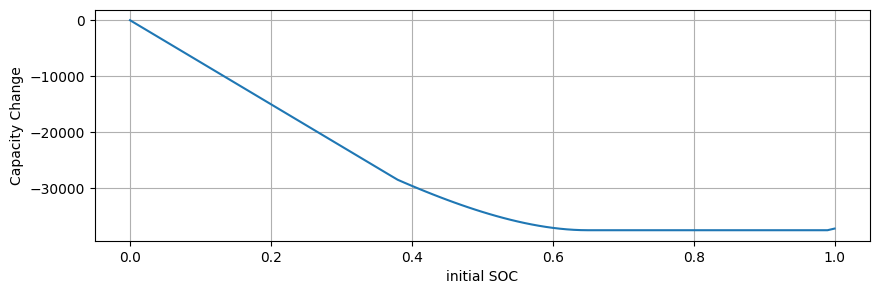

In [20]:
capacity_change = []
time_to_discharge = 3600

for initial_SOC in np.linspace(0,1,101) :

    bat1.EC = initial_SOC * bat1.NEC 
    new_SOC, _ = bat1.discharge(time_to_discharge) 
    capacity_change.append((new_SOC - initial_SOC) * bat1.NEC)
    


plt.figure(figsize=(10,3))
plt.grid(True)
X = np.linspace(0,1,101)
Y = capacity_change
plt.plot(X,Y)
plt.ylabel("Capacity Change")
plt.xlabel("initial SOC")
plt.show()


